In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib import colors
import matplotlib
import json
import os
import cv2
print(cv2.__version__)
# Load ball_detection code from the parent directory (because it is used for object detection and event detection)
import sys
sys.path.append("..")
from fmo_detection import detect_ball, plot_trajectory

3.1.0


/Users/ninawiedemann/anaconda/envs/baseball_analysis3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Release frame tests

The ball is found and then using an approximation for the speed, and the distance to the pitcher, we can calculate back when ball release must have occured

## 2D speed estimation 

Speed can be estimated in 2D as well, if the factor to transform pixel to meters is known. However, of course this is very imprecise. For example, in this side view you can see that the distances between the balls seem larger in the end (close to the batter), simply because the ball is closer to the camera. For estimating the release frame though, this rough approximation is sufficient. The pipeline is thus the following:

* <span style="color:green"> * For this video material, measure the pixel distance between pitcher's mound and batter's base* </span>
* <span style="color:red"> * Run ball detection for each video *</span>
* When the first ball that is detected (= the first triple of balls), <span style="color:blue">* it's location is projected orthogonally onto the line connection pitcher's mound and batter* </span>, and <span style="color:yellow">* it's distance to the pitcher's mound is estimated*</span>
* Estimated speed of the ball: mean pixel distance between each ball of the triple / the seconds between each frame (with a frame rate of 30 fps, this would be 1/30 second), than converted from pixels to miles
* Find the number of frames that must have passed since ball release: t = distance / speed
* BALL RELEASE FRAME = current frame - t

Note that of course this experiments here only work for exactly this video material!! For other videos, the pixel distance between pitcher's mound and batter's base needs to be set in the config file

The speed estimation is roughly correct, but you can for example see that the start speed is much lower than the mean speed because then the distances between balls become larger because of the viewpoint. The speed error is lower for the first few balls.

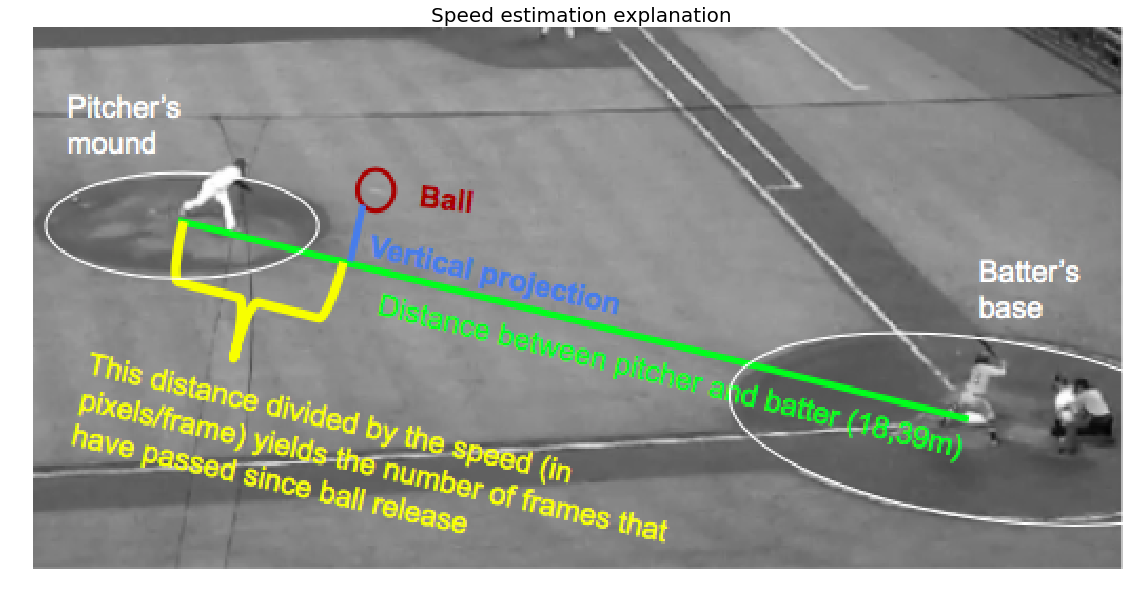

In [2]:
img = plt.imread(os.path.join("..", "assets","2D speed estimation explanation.png"))
plt.figure(figsize=(20,10))
plt.imshow(img)
plt.axis("off")
plt.title("Speed estimation explanation", fontsize=20)
plt.show()

## Functions for 2D speed estimation and release frame

### Specify first three constants dependent on the video

In [2]:
# CONSTANTS DEPENDENT ON VIDEO MATERIAL
pitcher_mound = np.array([750, 550])
batter_base =  np.array([1300, 690])
framerate = 30

# AUTOMATIC CONSTANTS
DISTANCE_P_B_pixels = np.linalg.norm(pitcher_mound-batter_base) # distance pitcher batter in pixels
DISTANCE_P_B_feet = 60.33 # distance pitcher batter in feet (always the same, official baseball measures)
FEET_PER_SECOND_TO_MPH = 0.681818 # factor to change units

def dist_per_frame(trajectory):
    """
    calculates the pixels per frame that the ball has travelled on average
    """
    trajectory = np.asarray(trajectory)
    # print(trajectory)
    distances = []
    for i in range(len(trajectory)-1):
        frame_difference = trajectory[i+1, 2] - trajectory[i,2]
        dist_difference = np.linalg.norm(trajectory[i,:2]- trajectory[i+1, :2])
        distances.append(dist_difference/frame_difference)
    mean_dist = np.mean(distances)
    return mean_dist
    
def speed_estimation_2D(trajectory):
    """
    calculates the speed in miles per hour from the 2D trajectory:
    input: array of shape (number ball detections, 3), where 3 includes x coordinate, y coordinate and frame
    """
    speed_in_pixels_per_frame = dist_per_frame(trajectory)
    speed_in_pixels_per_seconds = speed_in_pixels_per_frame*framerate
    speed_in_feet_per_seconds = speed_in_pixels_per_seconds / (DISTANCE_P_B_pixels / DISTANCE_P_B_feet)
    speed_in_mph = speed_in_feet_per_seconds * FEET_PER_SECOND_TO_MPH
    return speed_in_mph

def release_frame(trajectory):
    """
    calculate the release frame, given the 2D ball trajectory, and the location of pitcher and batter in the frame
    """
    def distance_projected(p, p1,p2):
        """
        returns distance of p' (= p projected on line spanned by p1 and p2) from p1
        """
        v1 = p-p1
        v2 = p2-p1
        v1_u = v1 / np.linalg.norm(v1)
        v2_u = v2 / np.linalg.norm(v2)
        return np.clip(np.dot(v1_u, v2_u), -1.0, 1.0) * np.linalg.norm(v1)
    
    nr_balls = len(trajectory)
    dist_from_start = distance_projected(trajectory[0, :2], pitcher_mound, batter_base)
    print("distance projected", dist_from_start)
    
    speed_in_pixels_per_frame = dist_per_frame(trajectory)
    print("speed_in_pixels_per_frame", speed_in_pixels_per_frame)
    
    # speed = np.mean([np.linalg.norm(trajectory[i]- trajectory[i+1]) for i in range(nr_balls-1)])
    frames_shifted = int(round(dist_from_start/speed_in_pixels_per_frame)) # frames because current frame is already after nth ball detection
    print("frames_shifted", frames_shifted)
    # print(dist_from_start, speed, frames_shifted)
    ball_release = trajectory[0,2] - frames_shifted
    return ball_release

## Run on side view videos, and display the found ball release frame:

### Specify data

In [3]:
PATH = os.path.join("..", "train_data", "ATL", "2017-05-22", "side view/")
# PATH = "/Volumes/Nina Backup/videos/atl/2017-05-22/side view/"


 ---------------------------------NEW VIDEO ---------------------------------------
File path: /Volumes/Nina Backup/videos/atl/2017-05-22/side view/490770-00e403bc-66f1-467a-9a84-c72f7dfa45ab.m4v
distance projected 2.02629409093
speed_in_pixels_per_frame 43.8426504134
frames_shifted 0

 BALL RELEASE FRAME: 100.0


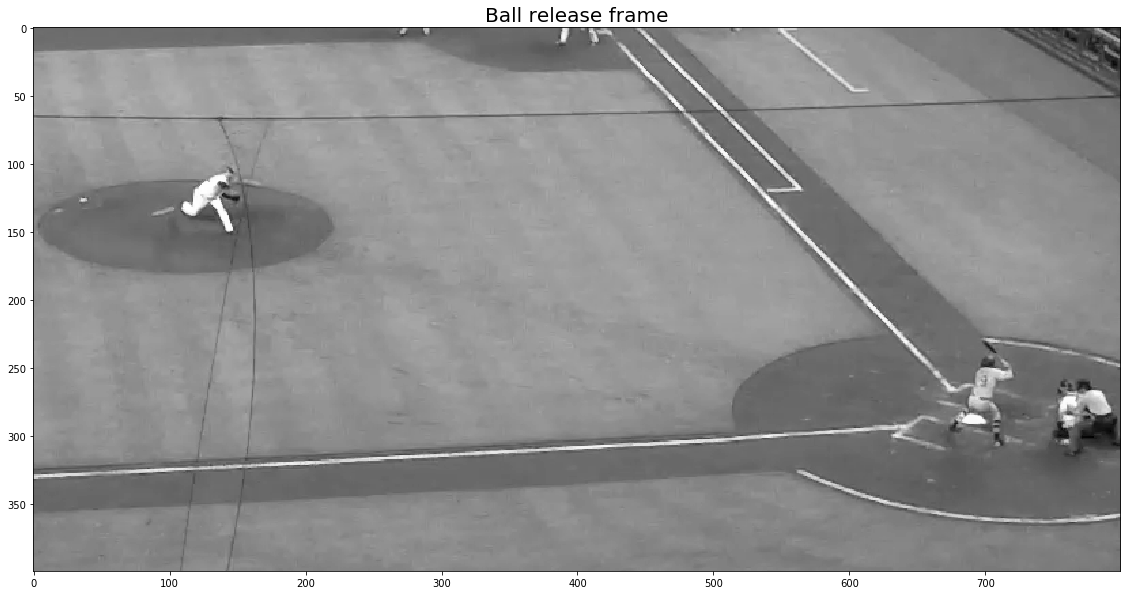


 BALL TRAJECTORY 

ball trajectory ([x,y,frame]) [[761.0, 515.0, 100.0], [803.0, 525.0, 101.0], [846.0, 536.5, 102.0], [888.5, 549.0, 103.0], [975.0, 572.0, 105.0], [1021.0, 587.5, 106.0], [1067.5, 601.0, 107.0], [1113.5, 615.0, 108.0], [1159.0, 629.5, 109.0], [1207.0, 645.0, 110.0], [1253.0, 661.0, 111.0]]


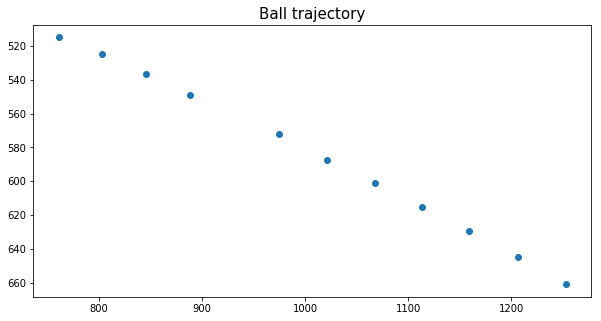

Speed estimation: MEAN over all detected balls, START only first three detections, STATCAST speed measured by radar with the Statcast system
MEAN     SPEED 101.90724759
START    SPEED 95.3288778151
STATCAST SPEED 89.589

 ---------------------------------NEW VIDEO ---------------------------------------
File path: /Volumes/Nina Backup/videos/atl/2017-05-22/side view/490770-03daf882-8539-4952-ae13-c924a1653a4d.m4v
distance projected 33.0638335794
speed_in_pixels_per_frame 46.2961373854
frames_shifted 1

 BALL RELEASE FRAME: 99.0


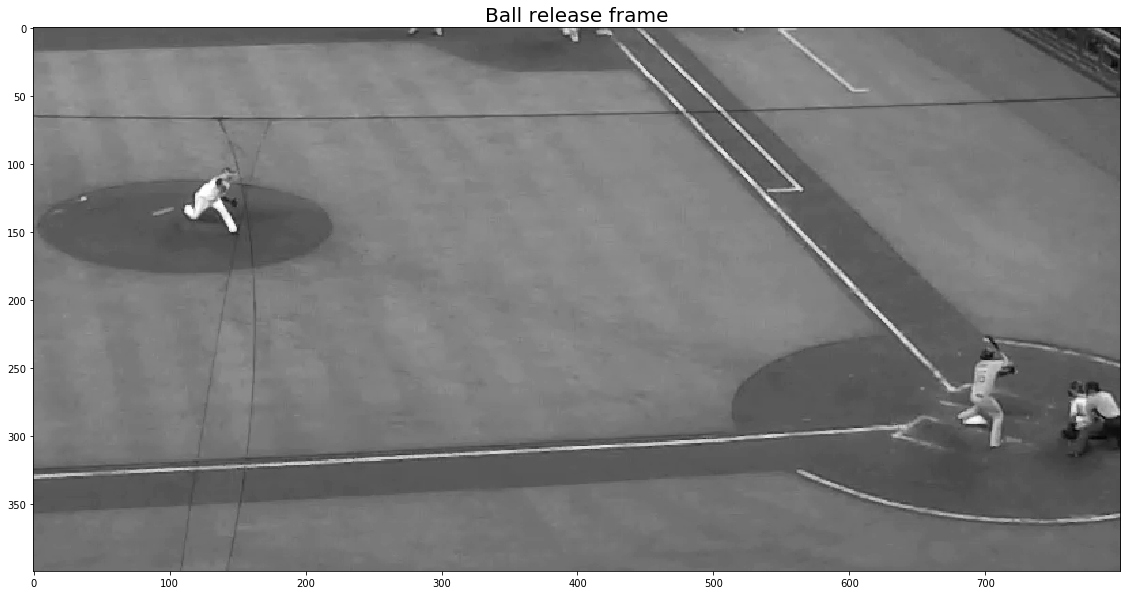


 BALL TRAJECTORY 

ball trajectory ([x,y,frame]) [[791.5, 521.0, 100.0], [836.0, 533.0, 101.0], [880.5, 546.5, 102.0], [1017.0, 587.5, 105.0], [1063.0, 602.5, 106.0], [1110.5, 617.0, 107.0], [1158.5, 633.0, 108.0], [1206.5, 649.0, 109.0], [1255.5, 664.0, 110.0]]


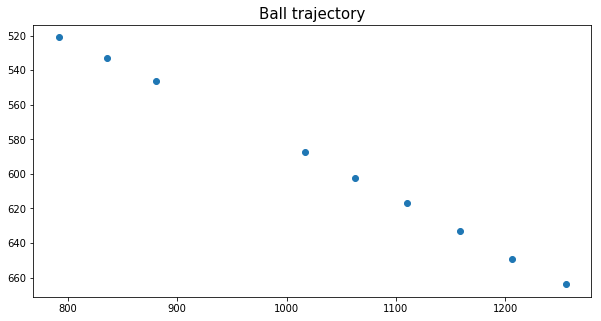

Speed estimation: MEAN over all detected balls, START only first three detections, STATCAST speed measured by radar with the Statcast system
MEAN     SPEED 106.158294325
START    SPEED 100.663595438
STATCAST SPEED 93.47

 ---------------------------------NEW VIDEO ---------------------------------------
File path: /Volumes/Nina Backup/videos/atl/2017-05-22/side view/490770-0457bc47-249c-4027-ba35-a06141be4e02.m4v
distance projected 2.27297337156
speed_in_pixels_per_frame 45.7227085838
frames_shifted 0

 BALL RELEASE FRAME: 98.0


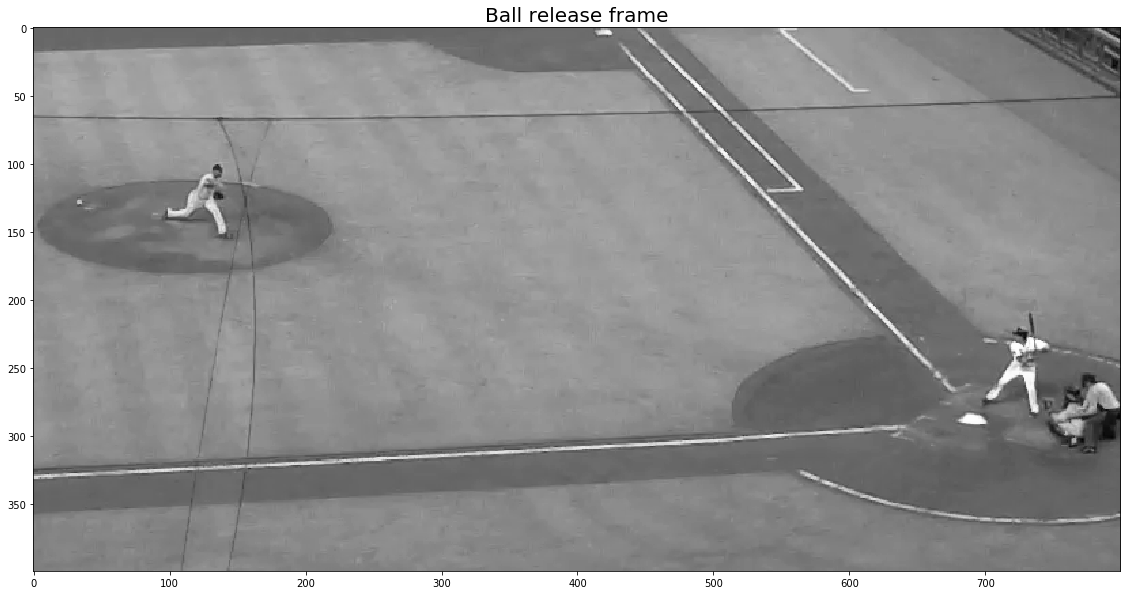


 BALL TRAJECTORY 

ball trajectory ([x,y,frame]) [[761.0, 516.0, 98.0], [804.5, 526.0, 99.0], [850.0, 537.0, 100.0], [895.0, 547.5, 101.0], [988.5, 570.5, 103.0], [1036.5, 583.5, 104.0], [1085.0, 595.0, 105.0], [1132.5, 608.5, 106.0], [1181.5, 621.0, 107.0], [1232.0, 636.0, 108.0], [1280.0, 649.0, 109.0], [1332.0, 664.0, 110.0]]


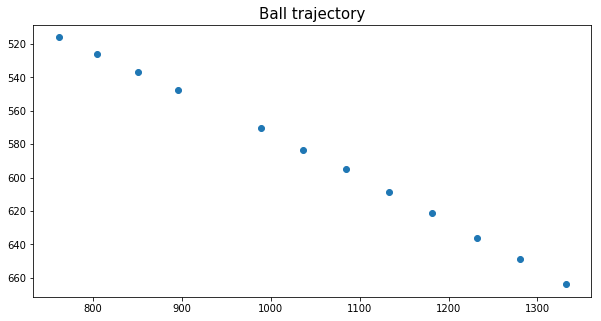

Speed estimation: MEAN over all detected balls, START only first three detections, STATCAST speed measured by radar with the Statcast system
MEAN     SPEED 107.106551205
START    SPEED 99.416765612
STATCAST SPEED 94.787

 ---------------------------------NEW VIDEO ---------------------------------------
File path: /Volumes/Nina Backup/videos/atl/2017-05-22/side view/490770-04819dc2-e122-441c-840e-98601242e8a4.m4v
distance projected 14.4571678401
speed_in_pixels_per_frame 40.5701893364
frames_shifted 0

 BALL RELEASE FRAME: 103.0


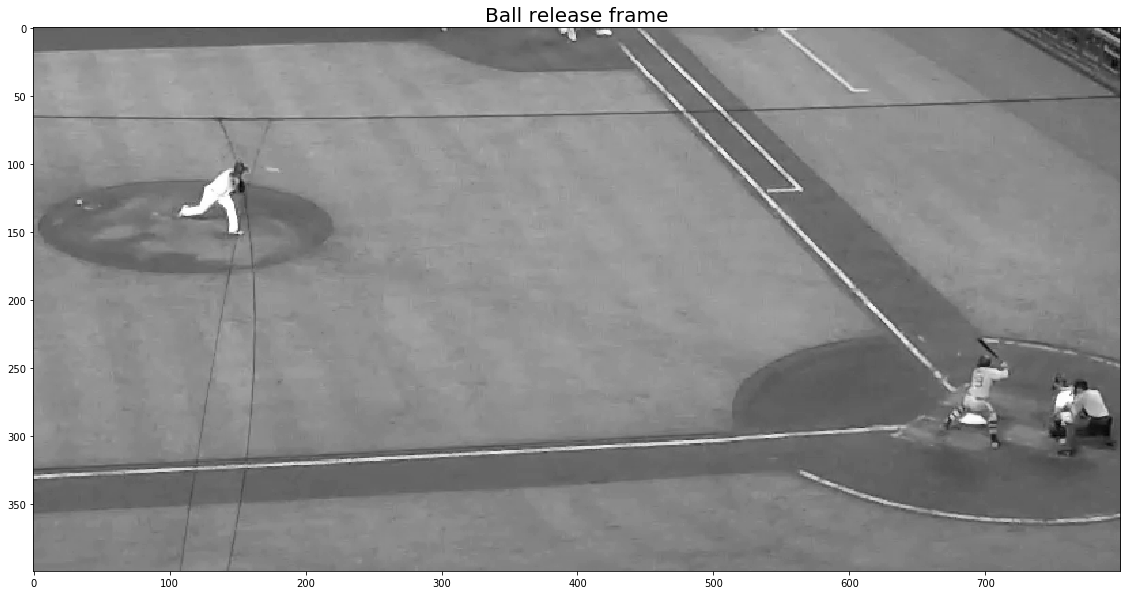


 BALL TRAJECTORY 

ball trajectory ([x,y,frame]) [[776.5, 504.5, 103.0], [815.5, 514.0, 104.0], [855.5, 523.0, 105.0], [896.0, 532.5, 106.0], [937.0, 543.5, 107.0], [978.0, 554.0, 108.0], [1020.0, 565.0, 109.0], [1063.0, 578.0, 110.0], [1106.0, 590.0, 111.0], [1149.5, 604.0, 112.0], [1192.5, 617.5, 113.0], [1236.0, 631.0, 114.0]]


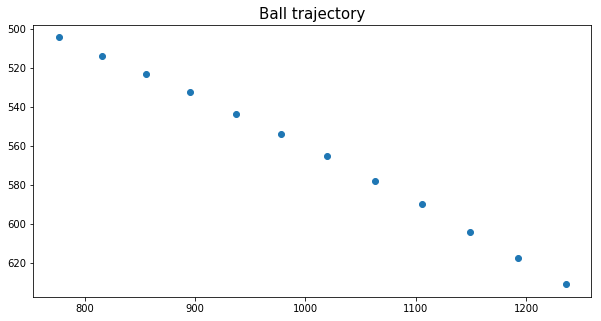

Speed estimation: MEAN over all detected balls, START only first three detections, STATCAST speed measured by radar with the Statcast system
MEAN     SPEED 94.2493865472
START    SPEED 88.2134311161
STATCAST SPEED 86.272

 ---------------------------------NEW VIDEO ---------------------------------------
File path: /Volumes/Nina Backup/videos/atl/2017-05-22/side view/490770-04b4f709-7996-4c61-858b-8a65409bdb43.m4v
distance projected 95.359161914
speed_in_pixels_per_frame 42.1012904252
frames_shifted 2

 BALL RELEASE FRAME: 104.0


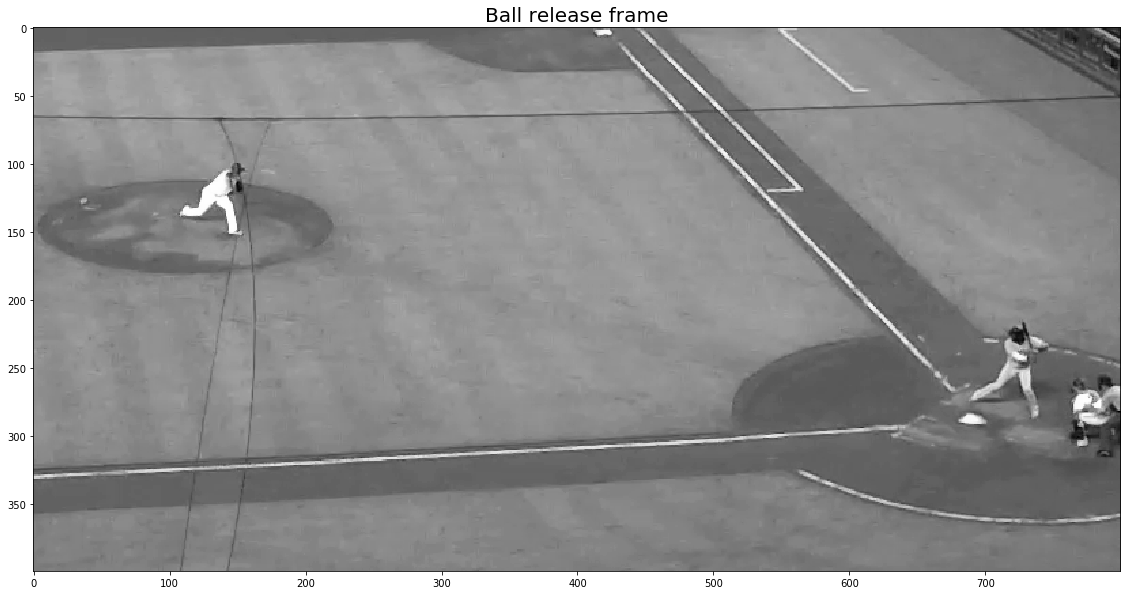


 BALL TRAJECTORY 

ball trajectory ([x,y,frame]) [[854.0, 528.0, 106.0], [894.0, 539.5, 107.0], [935.0, 551.0, 108.0], [1150.5, 621.0, 113.0], [1195.0, 637.0, 114.0], [1240.0, 652.5, 115.0], [1283.0, 670.0, 116.0], [1328.0, 687.5, 117.0]]


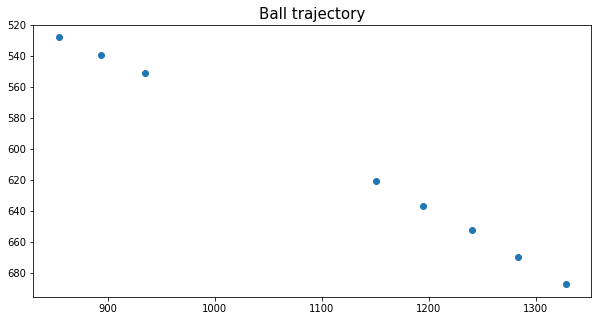

Speed estimation: MEAN over all detected balls, START only first three detections, STATCAST speed measured by radar with the Statcast system
MEAN     SPEED 99.1222145392
START    SPEED 91.5425671797
STATCAST SPEED 86.973


In [6]:
# Get speed labels for comparison
with open(os.path.join("..", "train_data", "speed_labels_sv.json"), "r") as infile:
    labels = json.load(infile)
    
# define region of interest (otherwise artifacts from motion of the audience)
box = [400, 800, 600, 1400]

videos = os.listdir(PATH)
j=0
for BASE in videos[:10]: # CHANGE NUMBER TO RUN MORE VIDEOS
    if BASE[-4:]!=".m4v":
        continue
    try:
        label_speed = labels[BASE[:-4]]
    except KeyError:
        continue
    print("\n ---------------------------------NEW VIDEO ---------------------------------------")
    print("File path:", os.path.join(PATH, BASE))
    
    # run ball detection
    ball_trajectory, _, _ = detect_ball(os.path.join(PATH, BASE), joints_array = None, plotting=False, min_area=30, roi = box) #400
    
    # execute release frame approximation (from above)
    ball_release = release_frame(ball_trajectory[:3])
    
    print("\n BALL RELEASE FRAME:", ball_release)
    
    # DISPLAY output frame
    cap = cv2.VideoCapture(os.path.join(PATH, BASE))
    cap.set(cv2.CAP_PROP_POS_FRAMES, ball_release)
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # cv2.circle(frame, (int(ball_trajectory[0,0]), int(ball_trajectory[0,1])), 10, color=[255,0,0])
    plt.figure(figsize=(20,10))
    plt.imshow(frame[box[0]:box[1], box[2]:box[3]])
    plt.title("Ball release frame", fontsize = 20)
    plt.gray()
    plt.show()
    
    j+=1
    print("\n BALL TRAJECTORY \n")
    print("ball trajectory ([x,y,frame])", ball_trajectory.tolist())
    if len(ball_trajectory)>0:
        #print(ball_release)
        #print(ball_trajectory)
        mean_speed = speed_estimation_2D(ball_trajectory)  #trajectory_and_speed(ball_trajectory)
        start_speed = speed_estimation_2D(ball_trajectory[:3])
        plot_trajectory(ball_trajectory)
        print("Speed estimation: MEAN over all detected balls, START only first three detections, STATCAST speed measured by radar with the Statcast system")
        print("MEAN     SPEED", mean_speed)
        print("START    SPEED", start_speed)
        print("STATCAST SPEED", label_speed)